In [13]:
import time
timestamp = time.time()
print(timestamp)
sample_interval = 0.1
rounded_timestamp = round(timestamp / sample_interval) * sample_interval
print(rounded_timestamp)

1732295199.1446583
1732295199.1000001


In [14]:
next_time = time.time()
print(next_time)
next_time = next_time - (next_time % sample_interval)
print(next_time)

1732295247.892652
1732295247.8000002


In [18]:
import datetime
timestamp_str = datetime.datetime.fromtimestamp(timestamp).strftime('%H:%M:%S.%f')
print(timestamp_str)

17:06:39.144658


In [19]:
import os
import time
import threading
import subprocess
import pynvml
from datetime import datetime
from threading import Thread, Event
import argparse
import socket
import struct
import json

In [26]:
import threading
import time
import random

def thread_function(name, barrier, measurements,sample_interval=0.1):
    while not stop_event.is_set():
        # Wait until all threads have reached this point
        barrier.wait()
        # Take the measurement
        measurement = take_measurement(name)
        timestamp = time.time()
        next_time= timestamp + sample_interval
        rounded_timestamp = round((timestamp / sample_interval) * sample_interval, 1)
        measurements.append((rounded_timestamp, measurement))
        # Sleep to simulate work and control the measurement interval
        sleep_time = next_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            pass

def take_measurement(thread_name):
    # Replace this with actual measurement code
    return f"Measurement from {thread_name} {round(random.random(),1)}"

# Parameters
measurement_interval = 0.1  # Time between measurements in seconds
total_runtime = 1  # Total time to run the measurement in seconds

# Synchronization primitives
num_threads = 2
barrier = threading.Barrier(num_threads)
stop_event = threading.Event()

# Data storage
measurements_a = []
measurements_b = []

# Create and start threads
thread_a = threading.Thread(target=thread_function, args=("Thread A", barrier, measurements_a))
thread_b = threading.Thread(target=thread_function, args=("Thread B", barrier, measurements_b))
thread_a.start()
thread_b.start()

# Let the threads run for the specified total runtime
time.sleep(total_runtime)
stop_event.set()

# Wait for threads to finish
thread_a.join()
thread_b.join()

# Print measurements
print("Measurements from Thread A:")
for timestamp, measurement in measurements_a:
    print(f"Time: {timestamp}, Measurement: {measurement}")

print("\nMeasurements from Thread B:")
for timestamp, measurement in measurements_b:
    print(f"Time: {timestamp}, Measurement: {measurement}")


Measurements from Thread A:
Time: 1732302022.6, Measurement: Measurement from Thread A 0.7
Time: 1732302022.7, Measurement: Measurement from Thread A 0.9
Time: 1732302022.8, Measurement: Measurement from Thread A 0.8
Time: 1732302022.9, Measurement: Measurement from Thread A 0.7
Time: 1732302023.0, Measurement: Measurement from Thread A 0.6
Time: 1732302023.1, Measurement: Measurement from Thread A 0.5
Time: 1732302023.2, Measurement: Measurement from Thread A 1.0
Time: 1732302023.3, Measurement: Measurement from Thread A 0.8
Time: 1732302023.4, Measurement: Measurement from Thread A 0.1
Time: 1732302023.5, Measurement: Measurement from Thread A 0.9

Measurements from Thread B:
Time: 1732302022.6, Measurement: Measurement from Thread B 0.5
Time: 1732302022.7, Measurement: Measurement from Thread B 0.5
Time: 1732302022.8, Measurement: Measurement from Thread B 0.9
Time: 1732302022.9, Measurement: Measurement from Thread B 0.6
Time: 1732302023.0, Measurement: Measurement from Thread B 0.

In [2]:
import threading
import time
import random
from queue import Queue, Empty

def thread_function(name, barrier, measurements_queue, sample_interval=0.1):
    while not stop_event.is_set():
        # Wait until all threads have reached this point
        barrier.wait()
        timestamp = time.time()
        # Round the timestamp to align to sample_interval
        rounded_timestamp = round((timestamp / sample_interval) * sample_interval, 1)
        # Take the measurement
        measurement = take_measurement(name)
        measurements_queue.put((rounded_timestamp, measurement))
        # Sleep to control the measurement interval
        next_time = timestamp + sample_interval
        sleep_time = next_time - time.time()
        if sleep_time > 0:
            time.sleep(sleep_time)
        else:
            pass

def take_measurement(thread_name):
    # Replace this with actual measurement code
    return f"Measurement from {thread_name} {round(random.random(),1)}"

def accumulator_function(measurements_a, measurements_b, sample_interval):
    data_a = {}
    data_b = {}
    processed_timestamps = set()
    last_measurement_a = None
    last_measurement_b = None

    while not stop_event.is_set() or not measurements_a.empty() or not measurements_b.empty():
        # Try to get new measurements from the queues
        try:
            while True:
                timestamp_a, measurement_a = measurements_a.get_nowait()
                data_a[timestamp_a] = measurement_a
        except Empty:
            pass

        try:
            while True:
                timestamp_b, measurement_b = measurements_b.get_nowait()
                data_b[timestamp_b] = measurement_b
        except Empty:
            pass

        # Get all timestamps that have measurements from at least one thread
        all_timestamps = set(data_a.keys()) | set(data_b.keys())
        pending_timestamps = sorted(all_timestamps - processed_timestamps)

        for timestamp in pending_timestamps:
            measurement_a = data_a.get(timestamp)
            measurement_b = data_b.get(timestamp)

            # If we have measurements from both threads, process them
            if measurement_a is not None and measurement_b is not None:
                print(f"Time: {timestamp}, Measurement A: {measurement_a}, Measurement B: {measurement_b}")
                last_measurement_a = measurement_a
                last_measurement_b = measurement_b
                processed_timestamps.add(timestamp)
                del data_a[timestamp]
                del data_b[timestamp]
            else:
                # If we don't have both measurements, check if we should fill in missing data
                time_since_timestamp = time.time() - timestamp
                if time_since_timestamp > sample_interval * 2:
                    # Fill in missing measurements using last known values
                    if measurement_a is None:
                        measurement_a = last_measurement_a
                    else:
                        last_measurement_a = measurement_a
                    if measurement_b is None:
                        measurement_b = last_measurement_b
                    else:
                        last_measurement_b = measurement_b

                    print(f"Time: {timestamp}, Measurement A: {measurement_a}, Measurement B: {measurement_b} (Filled)")
                    processed_timestamps.add(timestamp)
                    if timestamp in data_a:
                        del data_a[timestamp]
                    if timestamp in data_b:
                        del data_b[timestamp]

        time.sleep(0.01)

# Parameters
measurement_interval = 0.1  # Time between measurements in seconds
total_runtime = 1  # Total time to run the measurement in seconds

# Synchronization primitives
num_threads = 2
barrier = threading.Barrier(num_threads)
stop_event = threading.Event()

# Data storage
measurements_a = Queue()
measurements_b = Queue()

# Create and start threads
thread_a = threading.Thread(target=thread_function, args=("Thread A", barrier, measurements_a, measurement_interval))
thread_b = threading.Thread(target=thread_function, args=("Thread B", barrier, measurements_b, measurement_interval))
accumulator_thread = threading.Thread(target=accumulator_function, args=(measurements_a, measurements_b, measurement_interval))

thread_a.start()
thread_b.start()
accumulator_thread.start()

# Let the threads run for the specified total runtime
time.sleep(total_runtime)
stop_event.set()

# Wait for threads to finish
thread_a.join()
thread_b.join()
accumulator_thread.join()


Time: 1732303697.5, Measurement A: Measurement from Thread A 1.0, Measurement B: Measurement from Thread B 0.1
Time: 1732303697.6, Measurement A: Measurement from Thread A 0.3, Measurement B: Measurement from Thread B 0.8
Time: 1732303697.7, Measurement A: Measurement from Thread A 0.9, Measurement B: Measurement from Thread B 0.2
Time: 1732303697.8, Measurement A: Measurement from Thread A 0.1, Measurement B: Measurement from Thread B 0.1
Time: 1732303697.9, Measurement A: Measurement from Thread A 1.0, Measurement B: Measurement from Thread B 0.7
Time: 1732303698.0, Measurement A: Measurement from Thread A 0.4, Measurement B: Measurement from Thread B 0.3
Time: 1732303698.1, Measurement A: Measurement from Thread A 0.4, Measurement B: Measurement from Thread B 0.6
Time: 1732303698.2, Measurement A: Measurement from Thread A 0.7, Measurement B: Measurement from Thread B 0.0
Time: 1732303698.3, Measurement A: Measurement from Thread A 0.6, Measurement B: Measurement from Thread B 0.0
T

In [25]:
batch =[(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}), (1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}}), (1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}), (1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}}), (1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.2, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.4, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 9.0}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.5, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.7, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.8, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}}), (1732332508.9, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.74}}), (1732332509.1, {'cpu_memory': {'memory_energy': 1.35, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.74}}), (1732332509.2, {'cpu_memory': {'memory_energy': 1.35, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.74}}), (1732332509.3, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.98}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.5, {'cpu_memory': {'memory_energy': 1.34, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.6, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.96}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.8, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.78}}), (1732332509.9, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.78}})]

In [26]:
for i in batch:
    print(i)

(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}})
(1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.2, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.4, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 9.0}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.5, {'cpu_memory': {'memory_energy': 1.37, 'c

In [27]:
batch.sort(key=lambda x: x[0])
for i in batch:
    print(i)
timestamps = [entry[0] for entry in batch]
missed_timestamps=[]
for i in range(len(timestamps) - 1):
    if timestamps[i + 1] * 10 - timestamps[i] * 10 == 2:
        missed_timestamps.append((timestamps[i] * 10 + 1)/10)
        # print((timestamps[i] * 10 + 1)/10)
print(missed_timestamps)

(1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}})
(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.2, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.4, {'cpu_memory': {'memory_energy': 1.38, 'cpu_energy': 9.0}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.5, {'cpu_memory': {'memory_energy': 1.37, 'c

In [28]:
def fill_missing_timestamps(list_of_tuples, missing_timestamps):
    """
    Fills the missing timestamps in the list of tuples with measurements copied
    from the nearest timestamp.
    """
    # Sort the original list by timestamps
    list_of_tuples.sort(key=lambda x: x[0])
    
    # Combine original timestamps and measurements into a dictionary for easy access
    timestamp_to_measurement = {timestamp: measurement for timestamp, measurement in list_of_tuples}

    # Process each missing timestamp
    for missing in sorted(missing_timestamps):
        # Find the closest timestamp in the existing list
        closest_timestamp = min(timestamp_to_measurement.keys(), key=lambda t: abs(t - missing))
        # Copy the measurement of the closest timestamp to the missing timestamp
        timestamp_to_measurement[missing] = timestamp_to_measurement[closest_timestamp]

    # Create the new list of tuples, sorted by timestamps
    filled_list = sorted(timestamp_to_measurement.items(), key=lambda x: x[0])
    return filled_list

f_batch=fill_missing_timestamps(batch,missed_timestamps)
for i in f_batch:
    print(i)

(1732332507.3, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}})
(1732332507.4, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.5, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.6, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.7, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}})
(1732332507.8, {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}})
(1732332507.9, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.0, {'cpu_memory': {'memory_energy': 1.47, 'cpu_energy': 9.59}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.1, {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.94}, 'gpu': {'gpu_energy': 1.87}})
(1732332508.2, {'cpu_memory': {'memory_energy': 1.36, '

In [31]:
consolidated_data = [
            {
                'node_id': 'compute2',
                'timestamp': timestamp,
                'measurement': measurement
            }
            for timestamp, measurement in f_batch
        ]
print(consolidated_data, len(consolidated_data))

[{'node_id': 'compute2', 'timestamp': 1732332507.3, 'measurement': {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.99}, 'gpu': {'gpu_energy': 1.82}}}, {'node_id': 'compute2', 'timestamp': 1732332507.4, 'measurement': {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}}, {'node_id': 'compute2', 'timestamp': 1732332507.5, 'measurement': {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}}, {'node_id': 'compute2', 'timestamp': 1732332507.6, 'measurement': {'cpu_memory': {'memory_energy': 1.37, 'cpu_energy': 8.92}, 'gpu': {'gpu_energy': 1.68}}}, {'node_id': 'compute2', 'timestamp': 1732332507.7, 'measurement': {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.97}, 'gpu': {'gpu_energy': 1.68}}}, {'node_id': 'compute2', 'timestamp': 1732332507.8, 'measurement': {'cpu_memory': {'memory_energy': 1.36, 'cpu_energy': 8.93}, 'gpu': {'gpu_energy': 1.87}}}, {'node_id': 'compute2', 'timestamp': 1732332507.9, 'measu

In [29]:
import subprocess
import re
import sys
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
def parse_log_file(log_file):
    """
    Parses the log file to extract start and end times for data loading and computation phases.
    Returns a list of tuples: [(phase_name, start_time, end_time), ...]
    """
    time_pairs = []
    # phase_pattern = re.compile(
    #     r'(?P<phase>\w+ Phase): Start Time = (?P<start_time>[0-9.]+), End Time = (?P<end_time>[0-9.]+), Duration = [^\n]+'
    # )
    phase_pattern = re.compile(
    r'(?P<phase>[\w\s]+ [Pp]hase): Start Time = (?P<start_time>[0-9.]+), End Time = (?P<end_time>[0-9.]+), Duration = [^\n]+',
    re.IGNORECASE
    )
    with open(log_file, 'r') as f:
        for line in f:
            match = phase_pattern.search(line)
            if match:
                phase_name = match.group('phase')
                start_time = float(match.group('start_time'))
                end_time = float(match.group('end_time'))
                time_pairs.append((phase_name, start_time, end_time))
    return time_pairs

def read_inventory_file(inventory_file):
    """
    Reads the inventory file to get the list of IP addresses.
    """
    with open(inventory_file, 'r') as f:
        ips = [line.strip() for line in f if line.strip()]
    return ips

def run_query_on_node(ip, ssh_user, ssh_key, start_time, end_time):
    """
    SSH into the node, activate the pyenv environment, and run the query_database.py script.
    Returns the output from the script.
    """
    ssh_command = [
        'ssh',
        '-o', 'StrictHostKeyChecking=no',
        f'{ssh_user}@{ip}',
    ]
    if ssh_key:
        ssh_command.extend(['-i', ssh_key])

    # Construct the remote command with pyenv activation
    # Assuming pyenv is initialized in ~/.bashrc
    remote_command = (
        f'python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start {start_time} --end {end_time}'
    )
    full_command = ssh_command + [remote_command]
    # print(full_command)

    try:
        result = subprocess.run(full_command, capture_output=True, text=True, timeout=120)
        if result.returncode != 0:
            print(f"Error executing command on {ip}: {result.stderr}", file=sys.stderr)
            return None
        return result.stdout.strip()
    except subprocess.TimeoutExpired:
        print(f"Timeout occurred while querying {ip}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Exception occurred while querying {ip}: {e}", file=sys.stderr)
        return None


def parse_query_output(output):
    """
    Parses the output from query_database.py.
    Returns a dictionary with the parsed values.
    Example output:
    compute2: Number of entries: 158, CPU Energy: 1511.24, Memory Energy: 227.95, GPU Energy: 972.18
    """
    pattern = re.compile(
        r'(?P<node>\w+): Number of entries: (?P<entries>\d+), CPU Energy: (?P<cpu_energy>[0-9.]+), '
        r'Memory Energy: (?P<memory_energy>[0-9.]+), GPU Energy: (?P<gpu_energy>[0-9.]+)'
    )
    match = pattern.search(output)
    if match:
        return {
            'node': match.group('node'),
            'entries': int(match.group('entries')),
            'cpu_energy': float(match.group('cpu_energy')),
            'memory_energy': float(match.group('memory_energy')),
            'gpu_energy': float(match.group('gpu_energy')),
        }
    else:
        print(f"Failed to parse output: {output}", file=sys.stderr)
        return None

def adjust_energy_values(parsed_output, start_time, end_time):
    """
    Adjusts the energy values based on the expected number of entries.
    """
    actual_entries = parsed_output['entries']
    duration = end_time - start_time
    expected_entries = duration / 0.1  # 0.1s resolution
    if actual_entries == 0:
        print(f"No entries for node {parsed_output['node']} between {start_time} and {end_time}", file=sys.stderr)
        return None

    adjustment_factor = expected_entries / actual_entries

    adjusted_cpu_energy = parsed_output['cpu_energy'] * adjustment_factor
    adjusted_memory_energy = parsed_output['memory_energy'] * adjustment_factor
    adjusted_gpu_energy = parsed_output['gpu_energy'] * adjustment_factor

    return {
        'node': parsed_output['node'],
        'adjusted_cpu_energy': adjusted_cpu_energy,
        'adjusted_memory_energy': adjusted_memory_energy,
        'adjusted_gpu_energy': adjusted_gpu_energy,
    }

In [41]:
time_pairs = parse_log_file("/home/cc/imagenetTrainingWithResnet/results/b32_w0_lfb.txt")
# print(time_pairs)
ips = read_inventory_file("inventory.txt")
print(ips)
    # Iterate over each time pair
final_results = {}

base_energies={"compute1":{"memory":13.5,"cpu":85.2,"gpu":18},"compute2":{"memory":13.4,"cpu":88.2,"gpu":15},"storage1":{"memory":15.8,"cpu":187.2,"gpu":0},"storage2":{"memory":7.4,"cpu":87.2,"gpu":0},"storage3":{"memory":8.3,"cpu":82.5,"gpu":0}}

for phase_name, start_time, end_time in time_pairs:
    print(f"\nProcessing phase '{phase_name}' from {start_time} to {end_time}")
    expected_entries = math.ceil((end_time - start_time) / 0.1)
    duration = round(end_time - start_time,2)
    print(f"Expected entries: {expected_entries:.2f}")
    with ThreadPoolExecutor(max_workers=4) as executor:
        future_to_ip = {
            executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", start_time, end_time): ip
            for ip in ips
        }
        for future in as_completed(future_to_ip):
            ip = future_to_ip[future]
            try:
                output = future.result()
                # print(output)
                if output is None:
                    continue
                parsed_output = parse_query_output(output)
                # print(parsed_output)
                if parsed_output is None:
                    continue
                adjusted_values = adjust_energy_values(parsed_output, start_time, end_time)
                # print(adjusted_values)
                if adjusted_values is None:
                    continue
    
                node = adjusted_values['node']
                if node not in final_results:
                    final_results[node] = {}
    
                # Store the adjusted energy values under the phase name
                final_results[node][phase_name] = {
                    'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                    'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                    'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                    'Duration': duration
                }
    
                print(f"Node {node}: Adjusted CPU Energy: {adjusted_values['adjusted_cpu_energy']:.2f}, "
                      f"Memory Energy: {adjusted_values['adjusted_memory_energy']:.2f}, "
                      f"GPU Energy: {adjusted_values['adjusted_gpu_energy']:.2f}, "
                      f"Duartion : {duration}")
                
    
            except Exception as e:
                print(f"Error processing node {ip}: {e}", file=sys.stderr)

    # Print the final dictionary
    print(f"\nFinal Results: {final_results}")
    # for node, phases in final_results.items():
    #     print(f"Node: {node}")
    #     for phase, energies in phases.items():
    #         # print(energies)
    #         print(f"  Phase: {phase}")
    #         print(f"    Adjusted CPU Energy: {energies['adjusted_cpu_energy']:.2f}")
    #         print(f"    Adjusted Memory Energy: {energies['adjusted_memory_energy']:.2f}")
    #         print(f"    Adjusted GPU Energy: {energies['adjusted_gpu_energy']:.2f}")
    #         print(f"    Duration:{energies['Duration']}")


['10.52.3.6', '10.52.3.76', '10.52.0.165', '10.52.3.53']

Processing phase 'Data Loading Phase' from 1732499321.4836566 to 1732499329.692882
Expected entries: 83.00
Node storage1: Adjusted CPU Energy: 1559.64, Memory Energy: 131.73, GPU Energy: 0.00, Duartion : 8.21
Node compute2: Adjusted CPU Energy: 766.18, Memory Energy: 113.80, GPU Energy: 500.61, Duartion : 8.21
Node storage3: Adjusted CPU Energy: 692.47, Memory Energy: 69.87, GPU Energy: 0.00, Duartion : 8.21
Node storage2: Adjusted CPU Energy: 746.22, Memory Energy: 63.05, GPU Energy: 0.00, Duartion : 8.21

Final Results: {'storage1': {'Data Loading Phase': {'adjusted_cpu_energy': 1559.641345766739, 'adjusted_memory_energy': 131.73273081426254, 'adjusted_gpu_energy': 0.0, 'Duration': 8.21}}, 'compute2': {'Data Loading Phase': {'adjusted_cpu_energy': 766.1842373309311, 'adjusted_memory_energy': 113.80418789916568, 'adjusted_gpu_energy': 500.6107276942995, 'Duration': 8.21}}, 'storage3': {'Data Loading Phase': {'adjusted_cpu_energ

In [42]:
print(base_energies)

{'compute1': {'memory': 13.5, 'cpu': 85.2, 'gpu': 18}, 'compute2': {'memory': 13.4, 'cpu': 88.2, 'gpu': 15}, 'storage1': {'memory': 15.8, 'cpu': 187.2, 'gpu': 0}, 'storage2': {'memory': 7.4, 'cpu': 87.2, 'gpu': 0}, 'storage3': {'memory': 8.3, 'cpu': 82.5, 'gpu': 0}}


In [43]:
print(final_results)

{'storage1': {'Data Loading Phase': {'adjusted_cpu_energy': 1559.641345766739, 'adjusted_memory_energy': 131.73273081426254, 'adjusted_gpu_energy': 0.0, 'Duration': 8.21}, 'ForwardBackward Pass phase': {'adjusted_cpu_energy': 670.2199118593162, 'adjusted_memory_energy': 56.556141503418225, 'adjusted_gpu_energy': 0.0, 'Duration': 3.54}}, 'compute2': {'Data Loading Phase': {'adjusted_cpu_energy': 766.1842373309311, 'adjusted_memory_energy': 113.80418789916568, 'adjusted_gpu_energy': 500.6107276942995, 'Duration': 8.21}, 'ForwardBackward Pass phase': {'adjusted_cpu_energy': 328.651596031189, 'adjusted_memory_energy': 48.46540317671639, 'adjusted_gpu_energy': 635.2220392186302, 'Duration': 3.54}}, 'storage3': {'Data Loading Phase': {'adjusted_cpu_energy': 692.468686918617, 'adjusted_memory_energy': 69.8707698234916, 'adjusted_gpu_energy': 0.0, 'Duration': 8.21}, 'ForwardBackward Pass phase': {'adjusted_cpu_energy': 299.521907704718, 'adjusted_memory_energy': 29.791017725187196, 'adjusted_g

In [49]:
import pandas as pd
def extract_name(file_path):
    basename = os.path.basename(file_path)
    name, _ = os.path.splitext(basename)
    parts = name.split('_')
    if len(parts) >= 2:
        first_part = parts[0]
        second_part = parts[1].capitalize()  # Capitalize the second part (e.g., "w0" -> "W0")
        result = first_part + second_part
        return result
    else:
        return None

name_directory="/home/cc/imagenetTrainingWithResnet/results/b32_w0_lfb.txt"
df={}
df['name']= extract_name(name_directory)
for node, phases in final_results.items():
    for phase, energies in phases.items():
        if phase == "Data Loading Phase":
            identifier = "DL"
        elif phase == "ForwardBackward Pass phase":
            identifier = "FBP"
        full_identifier=f"{node}_{identifier}"
        column_name= f"{full_identifier}_cpu"
        df[column_name]=energies['adjusted_cpu_energy']
        column_name= f"{full_identifier}_cpu_base"
        df[column_name]=base_energies[node]['cpu']*energies['Duration']
        column_name= f"{full_identifier}_memory"
        df[column_name]=energies['adjusted_memory_energy']
        column_name= f"{full_identifier}_memory_base"
        df[column_name]=base_energies[node]['memory']*energies['Duration']
        column_name= f"{full_identifier}_gpu"
        df[column_name]=energies['adjusted_gpu_energy']
        column_name= f"{full_identifier}_gpu_base"
        df[column_name]=base_energies[node]['gpu']*energies['Duration']
    

In [51]:
dataFrame= pd.DataFrame([df])

In [53]:
dataFrame

,name,storage1_DL_cpu,storage1_DL_cpu_base,storage1_DL_memory,storage1_DL_memory_base,storage1_DL_gpu,storage1_DL_gpu_base,storage1_FBP_cpu,storage1_FBP_cpu_base,storage1_FBP_memory,...,storage2_DL_memory,storage2_DL_memory_base,storage2_DL_gpu,storage2_DL_gpu_base,storage2_FBP_cpu,storage2_FBP_cpu_base,storage2_FBP_memory,storage2_FBP_memory_base,storage2_FBP_gpu,storage2_FBP_gpu_base
0,b32W0,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0


In [54]:
dataFrame.describe()

,storage1_DL_cpu,storage1_DL_cpu_base,storage1_DL_memory,storage1_DL_memory_base,storage1_DL_gpu,storage1_DL_gpu_base,storage1_FBP_cpu,storage1_FBP_cpu_base,storage1_FBP_memory,storage1_FBP_memory_base,...,storage2_DL_memory,storage2_DL_memory_base,storage2_DL_gpu,storage2_DL_gpu_base,storage2_FBP_cpu,storage2_FBP_cpu_base,storage2_FBP_memory,storage2_FBP_memory_base,storage2_FBP_gpu,storage2_FBP_gpu_base
count,1.000000,1.000,1.000000,1.000,1.0,1.0,1.000000,1.000,1.000000,1.000,...,1.000000,1.000,1.0,1.0,1.000000,1.000,1.000000,1.000,1.0,1.0
mean,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,55.932,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,55.932,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0
25%,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,55.932,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0
50%,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,55.932,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0
75%,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,55.932,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0
max,1559.641346,1536.912,131.732731,129.718,0.0,0.0,670.219912,662.688,56.556142,55.932,...,63.048878,60.754,0.0,0.0,318.722148,308.688,27.283254,26.196,0.0,0.0


In [70]:
import subprocess
import re
import sys
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed
import math
import pandas as pd

def parse_log_file(log_file):
    time_pairs = []
    phase_pattern = re.compile(
    r'(?P<phase>[\w\s]+ [Pp]hase): Start Time = (?P<start_time>[0-9.]+), End Time = (?P<end_time>[0-9.]+), Duration = [^\n]+',
    re.IGNORECASE
    )
    with open(log_file, 'r') as f:
        for line in f:
            match = phase_pattern.search(line)
            if match:
                phase_name = match.group('phase')
                start_time = float(match.group('start_time'))
                end_time = float(match.group('end_time'))
                time_pairs.append((phase_name, start_time, end_time))
    return time_pairs

def read_inventory_file(inventory_file):
    with open(inventory_file, 'r') as f:
        ips = [line.strip() for line in f if line.strip()]
    return ips

def run_query_on_node(ip, ssh_user, ssh_key, start_time, end_time):
    ssh_command = [
        'ssh',
        '-o', 'StrictHostKeyChecking=no',
        f'{ssh_user}@{ip}',
    ]
    if ssh_key:
        ssh_command.extend(['-i', ssh_key])
    remote_command = (
        f'python3 /home/cc/MultiNodeEnergyTracker/query_database.py --start {start_time} --end {end_time}'
    )
    full_command = ssh_command + [remote_command]
    try:
        result = subprocess.run(full_command, capture_output=True, text=True, timeout=120)
        if result.returncode != 0:
            print(f"Error executing command on {ip}: {result.stderr}", file=sys.stderr)
            return None
        return result.stdout.strip()
    except subprocess.TimeoutExpired:
        print(f"Timeout occurred while querying {ip}.", file=sys.stderr)
        return None
    except Exception as e:
        print(f"Exception occurred while querying {ip}: {e}", file=sys.stderr)
        return None


def parse_query_output(output):
    pattern = re.compile(
        r'(?P<node>\w+): Number of entries: (?P<entries>\d+), CPU Energy: (?P<cpu_energy>[0-9.]+), '
        r'Memory Energy: (?P<memory_energy>[0-9.]+), GPU Energy: (?P<gpu_energy>[0-9.]+)'
    )
    match = pattern.search(output)
    if match:
        return {
            'node': match.group('node'),
            'entries': int(match.group('entries')),
            'cpu_energy': float(match.group('cpu_energy')),
            'memory_energy': float(match.group('memory_energy')),
            'gpu_energy': float(match.group('gpu_energy')),
        }
    else:
        print(f"Failed to parse output: {output}", file=sys.stderr)
        return None

def adjust_energy_values(parsed_output, start_time, end_time):
    actual_entries = parsed_output['entries']
    duration = end_time - start_time
    expected_entries = math.ceil(duration / 0.1)  # 0.1s resolution
    if actual_entries == 0:
        print(f"No entries for node {parsed_output['node']} between {start_time} and {end_time}", file=sys.stderr)
        return None

    adjustment_factor = expected_entries / actual_entries

    adjusted_cpu_energy = parsed_output['cpu_energy'] * adjustment_factor
    adjusted_memory_energy = parsed_output['memory_energy'] * adjustment_factor
    adjusted_gpu_energy = parsed_output['gpu_energy'] * adjustment_factor

    return {
        'node': parsed_output['node'],
        'adjusted_cpu_energy': adjusted_cpu_energy,
        'adjusted_memory_energy': adjusted_memory_energy,
        'adjusted_gpu_energy': adjusted_gpu_energy,
    }

def extract_name(file_path):
    basename = os.path.basename(file_path)
    name, _ = os.path.splitext(basename)
    parts = name.split('_')
    if len(parts) >= 2:
        first_part = parts[0]
        second_part = parts[1].capitalize()  # Capitalize the second part (e.g., "w0" -> "W0")
        result = first_part + second_part
        return result
    else:
        return None
        
base_energies={"compute1":{"memory":13.5,"cpu":85.2,"gpu":18},"compute2":{"memory":13.4,"cpu":88.2,"gpu":15},"storage1":{"memory":15.8,"cpu":187.2,"gpu":0},"storage2":{"memory":7.4,"cpu":87.2,"gpu":0},"storage3":{"memory":8.3,"cpu":82.5,"gpu":0}}

def collect_and_process(txt_file):
    time_pairs = parse_log_file(txt_file)
    ips = read_inventory_file("inventory.txt")
    final_results = {}    
    for phase_name, start_time, end_time in time_pairs:
        print(f"\nProcessing phase '{phase_name}' from {start_time} to {end_time}")
        expected_entries = math.ceil((end_time - start_time) / 0.1)
        duration = round(end_time - start_time,2)
        print(f"Expected entries: {expected_entries:.2f}")
        with ThreadPoolExecutor(max_workers=4) as executor:
            future_to_ip = {
                executor.submit(run_query_on_node, ip, "cc", "~/.ssh/id_rsa", start_time, end_time): ip
                for ip in ips
            }
            for future in as_completed(future_to_ip):
                ip = future_to_ip[future]
                try:
                    output = future.result()
                    if output is None:
                        continue
                    parsed_output = parse_query_output(output)
                    if parsed_output is None:
                        continue
                    adjusted_values = adjust_energy_values(parsed_output, start_time, end_time)
                    if adjusted_values is None:
                        continue
                    node = adjusted_values['node']
                    if node not in final_results:
                        final_results[node] = {}
                    final_results[node][phase_name] = {
                        'adjusted_cpu_energy': adjusted_values['adjusted_cpu_energy'],
                        'adjusted_memory_energy': adjusted_values['adjusted_memory_energy'],
                        'adjusted_gpu_energy': adjusted_values['adjusted_gpu_energy'],
                        'Duration': duration
                    }
                except Exception as e:
                    print(f"Error processing node {ip}: {e}", file=sys.stderr)
    df={}
    df['name']= extract_name(txt_file)
    for node, phases in final_results.items():
        for phase, energies in phases.items():
            if phase == "Data Loading Phase":
                identifier = "DL"
                df['DL_duration'] = energies['Duration']
            elif phase == "ForwardBackward Pass phase":
                identifier = "FBP"
                df['FBP_duration'] = energies['Duration']
            full_identifier=f"{node}_{identifier}"
            column_name= f"{full_identifier}_cpu"
            df[column_name]=energies['adjusted_cpu_energy']
            column_name= f"{full_identifier}_cpu_base"
            df[column_name]=base_energies[node]['cpu']*energies['Duration']
            column_name= f"{full_identifier}_memory"
            df[column_name]=energies['adjusted_memory_energy']
            column_name= f"{full_identifier}_memory_base"
            df[column_name]=base_energies[node]['memory']*energies['Duration']
            column_name= f"{full_identifier}_gpu"
            df[column_name]=energies['adjusted_gpu_energy']
            column_name= f"{full_identifier}_gpu_base"
            df[column_name]=base_energies[node]['gpu']*energies['Duration']
            
    dataFrame= pd.DataFrame([df])
    print(dataFrame)
    return(dataFrame)
        

In [71]:
list_of_files=["b128_w0_iteration_no_5_lfb.txt" ,"b128_w8_iteration_no_5_lfb.txt","b32_w1_lfb.txt","b64_w0_lfb.txt","b64_w8_lfb.txt",
"b128_w1_iteration_no_5_lfb.txt","b32_w0_lfb.txt","b32_w8_lfb.txt","b64_w1_lfb.txt"]

base_directories= "/home/cc/imagenetTrainingWithResnet/results/"
df_list=[]
for file in list_of_files:
    fileName=base_directories+file
    df_list.append(collect_and_process(fileName))


Processing phase 'Data Loading Phase' from 1732500135.3262475 to 1732500148.8098946
Expected entries: 135.00

Processing phase 'ForwardBackward Pass phase' from 1732500164.9141433 to 1732500174.9563305
Expected entries: 101.00
     name  DL_duration  storage1_DL_cpu  storage1_DL_cpu_base  \
0  b128W0        13.48      2559.383588              2523.456   

   storage1_DL_memory  storage1_DL_memory_base  storage1_DL_gpu  \
0           217.04084                  212.984              0.0   

   storage1_DL_gpu_base  FBP_duration  storage1_FBP_cpu  ...  \
0                   0.0         10.04          1919.505  ...   

   storage2_DL_memory  storage2_DL_memory_base  storage2_DL_gpu  \
0          103.797744                   99.752              0.0   

   storage2_DL_gpu_base  storage2_FBP_cpu  storage2_FBP_cpu_base  \
0                   0.0        911.897374                875.488   

   storage2_FBP_memory  storage2_FBP_memory_base  storage2_FBP_gpu  \
0            77.678182             

In [72]:
final_df = pd.concat(df_list)
final_df.columns

Index(['name', 'DL_duration', 'storage1_DL_cpu', 'storage1_DL_cpu_base',
       'storage1_DL_memory', 'storage1_DL_memory_base', 'storage1_DL_gpu',
       'storage1_DL_gpu_base', 'FBP_duration', 'storage1_FBP_cpu',
       'storage1_FBP_cpu_base', 'storage1_FBP_memory',
       'storage1_FBP_memory_base', 'storage1_FBP_gpu', 'storage1_FBP_gpu_base',
       'compute2_DL_cpu', 'compute2_DL_cpu_base', 'compute2_DL_memory',
       'compute2_DL_memory_base', 'compute2_DL_gpu', 'compute2_DL_gpu_base',
       'compute2_FBP_cpu', 'compute2_FBP_cpu_base', 'compute2_FBP_memory',
       'compute2_FBP_memory_base', 'compute2_FBP_gpu', 'compute2_FBP_gpu_base',
       'storage3_DL_cpu', 'storage3_DL_cpu_base', 'storage3_DL_memory',
       'storage3_DL_memory_base', 'storage3_DL_gpu', 'storage3_DL_gpu_base',
       'storage3_FBP_cpu', 'storage3_FBP_cpu_base', 'storage3_FBP_memory',
       'storage3_FBP_memory_base', 'storage3_FBP_gpu', 'storage3_FBP_gpu_base',
       'storage2_DL_cpu', 'storage2_DL_cpu

In [73]:
final_df

,name,DL_duration,storage1_DL_cpu,storage1_DL_cpu_base,storage1_DL_memory,storage1_DL_memory_base,storage1_DL_gpu,storage1_DL_gpu_base,FBP_duration,storage1_FBP_cpu,...,storage2_DL_memory,storage2_DL_memory_base,storage2_DL_gpu,storage2_DL_gpu_base,storage2_FBP_cpu,storage2_FBP_cpu_base,storage2_FBP_memory,storage2_FBP_memory_base,storage2_FBP_gpu,storage2_FBP_gpu_base
0,b128W0,13.48,2559.383588,2523.456,217.040840,212.984,0.0,0.0,10.04,1919.505000,...,103.797744,99.752,0.0,0.0,911.897374,875.488,77.678182,74.296,0.0,0.0
0,b128W8,16.01,3063.778065,2997.072,259.033419,252.958,0.0,0.0,10.15,1952.125455,...,124.082803,118.474,0.0,0.0,915.599394,885.080,78.612121,75.110,0.0,0.0
0,b32W1,7.67,1459.191067,1435.824,123.384800,121.186,0.0,0.0,6.48,1232.552344,...,59.320395,56.758,0.0,0.0,588.849219,565.056,50.019531,47.952,0.0,0.0
0,b64W0,14.05,2674.893504,2630.160,227.514307,221.990,0.0,0.0,9.32,1788.003956,...,108.467826,103.970,0.0,0.0,855.992609,812.704,72.410652,68.968,0.0,0.0
0,b64W8,11.68,2223.749211,2186.496,188.195526,184.544,0.0,0.0,9.29,1765.140000,...,89.764435,86.432,0.0,0.0,842.845714,810.088,71.303407,68.746,0.0,0.0
0,b128W1,17.88,3401.997874,3347.136,288.899828,282.504,0.0,0.0,10.29,1956.367723,...,137.840056,132.312,0.0,0.0,936.568700,897.288,79.402700,76.146,0.0,0.0
0,b32W0,8.21,1576.887284,1536.912,133.189383,129.718,0.0,0.0,3.54,682.464706,...,63.746049,60.754,0.0,0.0,324.545143,308.688,27.781714,26.196,0.0,0.0
0,b32W8,6.75,1292.334769,1263.600,109.103385,106.650,0.0,0.0,6.52,1257.330938,...,52.390909,49.950,0.0,0.0,599.940000,568.544,50.725714,48.248,0.0,0.0
0,b64W1,16.80,3212.337485,3144.960,272.152209,265.440,0.0,0.0,9.27,1766.545333,...,130.180904,124.320,0.0,0.0,841.569130,808.344,71.630217,68.598,0.0,0.0


In [74]:
final_df['DL_cpu']=final_df["storage1_DL_cpu"]+final_df["storage2_DL_cpu"]+final_df["storage3_DL_cpu"]+final_df["compute2_DL_cpu"]
final_df['DL_cpu_base']=final_df["storage1_DL_cpu_base"]+final_df["storage2_DL_cpu_base"]+final_df["storage3_DL_cpu_base"]+final_df["compute2_DL_cpu_base"]
final_df['DL_memory']=final_df["storage1_DL_memory"]+final_df["storage2_DL_memory"]+final_df["storage3_DL_memory"]+final_df["compute2_DL_memory"]
final_df['DL_memory_base']=final_df["storage1_DL_memory_base"]+final_df["storage2_DL_memory_base"]+final_df["storage3_DL_memory_base"]+final_df["compute2_DL_memory_base"]
final_df['DL_gpu']=final_df["storage1_DL_gpu"]+final_df["storage2_DL_gpu"]+final_df["storage3_DL_gpu"]+final_df["compute2_DL_gpu"]
final_df['DL_gpu_base']=final_df["storage1_DL_gpu_base"]+final_df["storage2_DL_gpu_base"]+final_df["storage3_DL_gpu_base"]+final_df["compute2_DL_gpu_base"]

final_df['FBP_cpu']=final_df["storage1_FBP_cpu"]+final_df["storage2_FBP_cpu"]+final_df["storage3_FBP_cpu"]+final_df["compute2_FBP_cpu"]
final_df['FBP_cpu_base']=final_df["storage1_FBP_cpu_base"]+final_df["storage2_FBP_cpu_base"]+final_df["storage3_FBP_cpu_base"]+final_df["compute2_FBP_cpu_base"]
final_df['FBP_memory']=final_df["storage1_FBP_memory"]+final_df["storage2_FBP_memory"]+final_df["storage3_FBP_memory"]+final_df["compute2_FBP_memory"]
final_df['FBP_memory_base']=final_df["storage1_FBP_memory_base"]+final_df["storage2_FBP_memory_base"]+final_df["storage3_FBP_memory_base"]+final_df["compute2_FBP_memory_base"]
final_df['FBP_gpu']=final_df["storage1_FBP_gpu"]+final_df["storage2_FBP_gpu"]+final_df["storage3_FBP_gpu"]+final_df["compute2_FBP_gpu"]
final_df['FBP_gpu_base']=final_df["storage1_FBP_gpu_base"]+final_df["storage2_FBP_gpu_base"]+final_df["storage3_FBP_gpu_base"]+final_df["compute2_FBP_gpu_base"]

In [79]:
final_df.columns
final_df.describe

<bound method NDFrame.describe of      name  DL_duration  storage1_DL_cpu  storage1_DL_cpu_base  \
0  b128W0        13.48      2559.383588              2523.456   
0  b128W8        16.01      3063.778065              2997.072   
0   b32W1         7.67      1459.191067              1435.824   
0   b64W0        14.05      2674.893504              2630.160   
0   b64W8        11.68      2223.749211              2186.496   
0  b128W1        17.88      3401.997874              3347.136   
0   b32W0         8.21      1576.887284              1536.912   
0   b32W8         6.75      1292.334769              1263.600   
0   b64W1        16.80      3212.337485              3144.960   

   storage1_DL_memory  storage1_DL_memory_base  storage1_DL_gpu  \
0          217.040840                  212.984              0.0   
0          259.033419                  252.958              0.0   
0          123.384800                  121.186              0.0   
0          227.514307                  221.990 

In [125]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_energy_duration(df, names):
    x = np.arange(len(names))
    fig, ax1 = plt.subplots(figsize=(14, 8))
    width = 0.35  # the width of the bars
    # Create a second y-axis for durations
    ax2 = ax1.twinx()
    ax2.set_ylabel('Duration (s)')
    for name in names:
        filtered_df = df[df['name']== name].copy()
        # print(filtered_df)
        if filtered_df.empty:
            print("No matching names found in the DataFrame.")
            return
        DL_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
        DL_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}
    
        FBP_colors = {'cpu': 'orange', 'memory': 'purple', 'gpu': 'brown'}
        FBP_light_colors = {'cpu': 'moccasin', 'memory': 'plum', 'gpu': 'peru'}

        DL_bottoms = {'cpu': 0, 'memory': 0, 'gpu': 0}
        FBP_bottoms = {'cpu': 0, 'memory': 0, 'gpu': 0}

        # Plot DL stacked bars
        for idx, row in filtered_df.iterrows():
            pos = x[filtered_df.index.get_loc(idx)] - width/2  # Position for DL bars
            #CPU
            ax1.bar(pos, row['DL_cpu_base'], width, color=DL_light_colors['cpu'])
            ax1.bar(pos, row['DL_cpu'] - row['DL_cpu_base'], width, color=DL_colors['cpu'],bottom= row['DL_cpu_base'])
            # Memory
            ax1.bar(pos, row['DL_memory_base'], width, color=DL_light_colors['memory'], bottom=row['DL_cpu'])
            ax1.bar(pos, row['DL_memory'] - row['DL_memory_base'], width, color=DL_colors['memory'], bottom=row['DL_cpu']+row['DL_memory_base'])
            # # GPU
            ax1.bar(pos, row['DL_gpu_base'], width, color=DL_light_colors['gpu'], bottom=row['DL_cpu'] + row['DL_memory'])
            ax1.bar(pos, row['DL_gpu'] - row['DL_gpu_base'], width, color=DL_colors['gpu'], bottom=row['DL_cpu'] + row['DL_memory']+row['DL_gpu_base'])

        # Plot FBP stacked bars
        for idx, row in filtered_df.iterrows():
            pos = x[filtered_df.index.get_loc(idx)] + width/2  # Position for FBP bars
            # CPU
            ax1.bar(pos, row['FBP_cpu_base'], width, color=FBP_light_colors['cpu'])
            ax1.bar(pos, row['FBP_cpu'] - row['FBP_cpu_base'], width, color=FBP_colors['cpu'],bottom= row['FBP_cpu_base'])
            # Memory
            ax1.bar(pos, row['FBP_memory_base'], width, color=FBP_light_colors['memory'], bottom=row['FBP_cpu'])
            ax1.bar(pos, row['FBP_memory'] - row['FBP_memory_base'], width, color=FBP_colors['memory'], bottom=row['FBP_cpu']+row['FBP_memory_base'])
            # GPU
            ax1.bar(pos, row['FBP_gpu_base'], width, color=FBP_light_colors['gpu'], bottom=row['FBP_cpu'] + row['FBP_memory'])
            ax1.bar(pos, row['FBP_gpu'] - row['FBP_gpu_base'], width, color=FBP_colors['gpu'], bottom=row['FBP_cpu'] + row['FBP_memory']+row['FBP_gpu_base'])
        # Customize x-axis
    
        # Plot durations as points
        ax2.scatter(x - width/2, filtered_df['DL_duration'], color='black', marker='x', label='DL Duration')
        ax2.scatter(x + width/2, filtered_df['FBP_duration'], color='gray', marker='x', label='FBP Duration')
    
        # Add legends
        # handles1, labels1 = ax1.get_legend_handles_labels()
        # handles2, labels2 = ax2.get_legend_handles_labels()
        # ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper left', bbox_to_anchor=(1, 1))
    
    # Add grid for better readability
    filtered_df = df[df['name'].isin(names)].copy()
    ax1.set_xticks(x)
    ax1.set_xticklabels(filtered_df['name'], rotation=45, ha='right')
    ax1.set_xlabel('Name')
    ax1.set_ylabel('Energy Consumption (Joules)')

    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Set plot title
    plt.title('Energy Consumption and Duration per Node')

    # Adjust layout to prevent clipping of tick-labels and legends
    plt.tight_layout()

    # Show the plot
    plt.show()


ValueError: x and y must be the same size

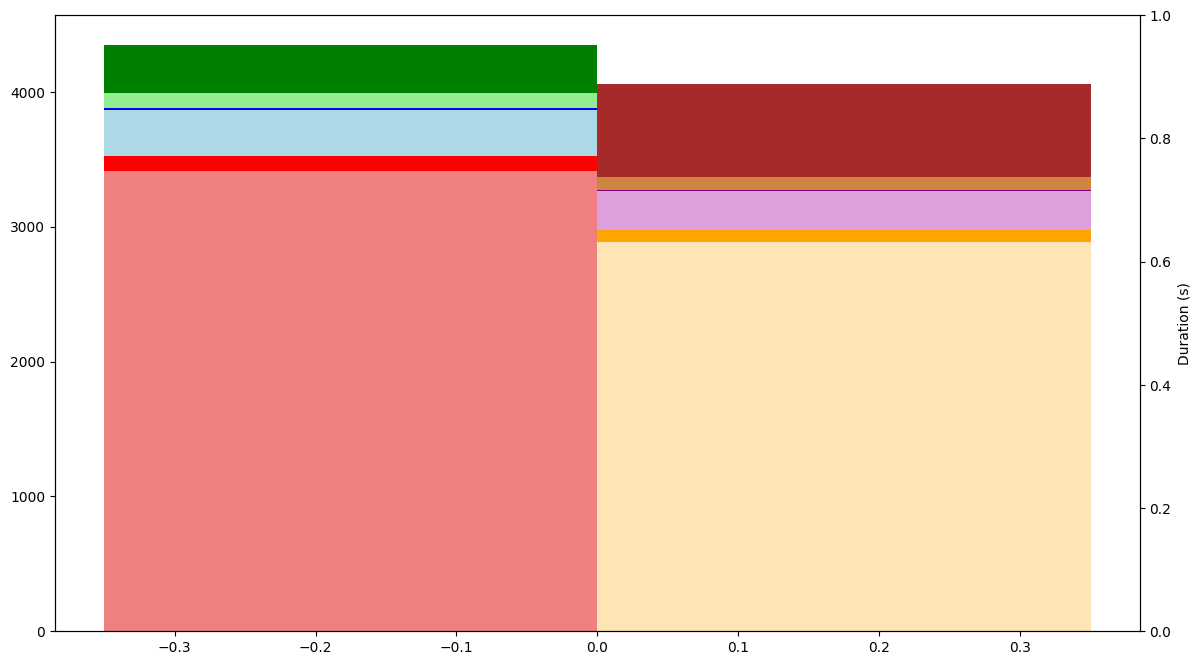

In [126]:
plot_energy_duration(final_df, ['b32W1','b64W1', ])

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

def plot_energy_duration(df, names):
    """
    Plots energy consumption and duration for specified names.

    Parameters:
    - df (pd.DataFrame): DataFrame containing energy and duration data.
    - names (list): List of names to filter and plot.

    The function filters the DataFrame for the specified names and creates a plot with:
    - Two stacked bar plots per name (DL and FBP) on the primary y-axis.
    - Points representing durations on the secondary y-axis.
    """
    # Initialize final_results
    final_results = {}

    # Filter the DataFrame for the specified names
    filtered_df = df[df['name'].isin(names)].copy()

    if filtered_df.empty:
        print("No matching names found in the DataFrame.")
        return

    # Check for duplicate names
    if filtered_df['name'].duplicated().any():
        print("Duplicate names found in the DataFrame. Aggregating data.")
        # Aggregate by summing the energy and durations
        grouped_df = filtered_df.groupby('name').sum().reset_index()
    else:
        grouped_df = filtered_df.reset_index(drop=True)

    # Ensure that grouped_df has the same order as 'names'
    grouped_df['name'] = pd.Categorical(grouped_df['name'], categories=names, ordered=True)
    grouped_df.sort_values('name', inplace=True)

    # Define x positions
    x = np.arange(len(grouped_df))
    width = 0.35  # the width of the bars

    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Create a second y-axis for durations
    ax2 = ax1.twinx()
    ax2.set_ylabel('Duration (s)')
    # ax2.set_ylim(bottom=0) 
    ax2.set_yscale('log',base=2)
    # Define colors
    DL_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
    DL_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}

    FBP_colors = {'cpu': 'red', 'memory': 'blue', 'gpu': 'green'}
    FBP_light_colors = {'cpu': 'lightcoral', 'memory': 'lightblue', 'gpu': 'lightgreen'}

    # Plot DL stacked bars
    # CPU
    ax1.bar(x - width/2, grouped_df['DL_cpu_base'], width, color=DL_light_colors['cpu'], label='DL_cpu_base')
    ax1.bar(x - width/2, grouped_df['DL_cpu'] - grouped_df['DL_cpu_base'], width, color=DL_colors['cpu'], bottom=grouped_df['DL_cpu_base'], label='DL_cpu')

    # Memory
    ax1.bar(x - width/2, grouped_df['DL_memory_base'], width, color=DL_light_colors['memory'], bottom=grouped_df['DL_cpu'], label='DL_memory_base')
    ax1.bar(x - width/2, grouped_df['DL_memory'] - grouped_df['DL_memory_base'], width, color=DL_colors['memory'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory_base'], label='DL_memory')

    # GPU
    ax1.bar(x - width/2, grouped_df['DL_gpu_base'], width, color=DL_light_colors['gpu'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory'], label='DL_gpu_base')
    ax1.bar(x - width/2, grouped_df['DL_gpu'] - grouped_df['DL_gpu_base'], width, color=DL_colors['gpu'], bottom=grouped_df['DL_cpu'] + grouped_df['DL_memory'] + grouped_df['DL_gpu_base'], label='DL_gpu')

    # Plot FBP stacked bars
    # CPU
    ax1.bar(x +0.01+width/2, grouped_df['FBP_cpu_base'], width, color=FBP_light_colors['cpu'], label='FBP_cpu_base')
    ax1.bar(x +0.01+width/2, grouped_df['FBP_cpu'] - grouped_df['FBP_cpu_base'], width, color=FBP_colors['cpu'], bottom=grouped_df['FBP_cpu_base'], label='FBP_cpu')

    # Memory
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_memory_base'], width, color=FBP_light_colors['memory'], bottom=grouped_df['FBP_cpu'], label='FBP_memory_base')
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_memory'] - grouped_df['FBP_memory_base'], width, color=FBP_colors['memory'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory_base'], label='FBP_memory')

    # GPU
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_gpu_base'], width, color=FBP_light_colors['gpu'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory'], label='FBP_gpu_base')
    ax1.bar(x +0.01+ width/2, grouped_df['FBP_gpu'] - grouped_df['FBP_gpu_base'], width, color=FBP_colors['gpu'], bottom=grouped_df['FBP_cpu'] + grouped_df['FBP_memory'] + grouped_df['FBP_gpu_base'], label='FBP_gpu')

    # Plot durations as points
    ax2.scatter(x - width/2, grouped_df['DL_duration'], color='black', marker='o', label='DL Duration')
    ax2.scatter(x + width/2, grouped_df['FBP_duration'], color='black', marker='x', label='FBP Duration')

    # Customize x-axis
    ax1.set_xticks(x)
    ax1.set_xticklabels(grouped_df['name'], rotation=45, ha='right')
    ax1.set_xlabel('Name')
    ax1.set_ylabel('Energy Consumption (Joules)')

    # Add legends
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    # Remove duplicates
    by_label1 = dict(zip(labels1, handles1))
    by_label2 = dict(zip(labels2, handles2))
    ax1.legend(by_label1.values(), by_label1.keys(), loc='upper left', bbox_to_anchor=(1, 1))
    ax2.legend(by_label2.values(), by_label2.keys(), loc='upper left', bbox_to_anchor=(1, 0.15))

    # Add grid for better readability
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Set plot title
    plt.title('Energy Consumption and Duration for Different Configurations')
    # Calculate and print statistics
    print("\nStatistical Summary:")
    for i, row in grouped_df.iterrows():
        # Total duration
        total_duration = row['DL_duration'] + row['FBP_duration']
        if total_duration > 0:
            dl_duration_pct = (row['DL_duration'] / total_duration) * 100
        else:
            dl_duration_pct = 0
        
        # Total energy (DL + FBP)
        total_energy = (row['DL_cpu'] + row['DL_memory'] + row['DL_gpu']) + (row['FBP_cpu'] + row['FBP_memory'] + row['FBP_gpu'])
        if total_energy > 0:
            dl_energy = row['DL_cpu'] + row['DL_memory'] + row['DL_gpu']
            dl_energy_pct = (dl_energy / total_energy) * 100
        else:
            dl_energy_pct = 0
        
        # Print statistics
        print(f"\nName: {row['name']}")
        print(f"  Data Loading took {dl_duration_pct:.1f}% time between Data Loading + FBP")
        print(f"  Data Loading consumed {dl_energy_pct:.1f}% of total energy consumption of Data Loading + FBP")
    
    # Adjust y-axis limits to accommodate annotations (optional)
    max_energy = grouped_df[['DL_cpu', 'DL_memory', 'DL_gpu', 'FBP_cpu', 'FBP_memory', 'FBP_gpu']].sum(axis=1).max()
    # ax1.set_ylim(top=max_energy * 1.1)  # 10% more space at the top
    
    # Adjust layout to prevent clipping of tick-labels and legends
    plt.tight_layout()
    
    # Show the plot
    plt.show()





Statistical Summary:

Name: b32W0
  Data Loading took 69.9% time between Data Loading + FBP
  Data Loading consumed 65.6% of total energy consumption of Data Loading + FBP

Name: b32W1
  Data Loading took 54.2% time between Data Loading + FBP
  Data Loading consumed 51.7% of total energy consumption of Data Loading + FBP

Name: b32W8
  Data Loading took 50.9% time between Data Loading + FBP
  Data Loading consumed 48.2% of total energy consumption of Data Loading + FBP

Name: b64W0
  Data Loading took 60.1% time between Data Loading + FBP
  Data Loading consumed 56.2% of total energy consumption of Data Loading + FBP

Name: b64W1
  Data Loading took 64.4% time between Data Loading + FBP
  Data Loading consumed 61.0% of total energy consumption of Data Loading + FBP

Name: b64W8
  Data Loading took 55.7% time between Data Loading + FBP
  Data Loading consumed 52.3% of total energy consumption of Data Loading + FBP

Name: b128W0
  Data Loading took 57.3% time between Data Loading + FBP


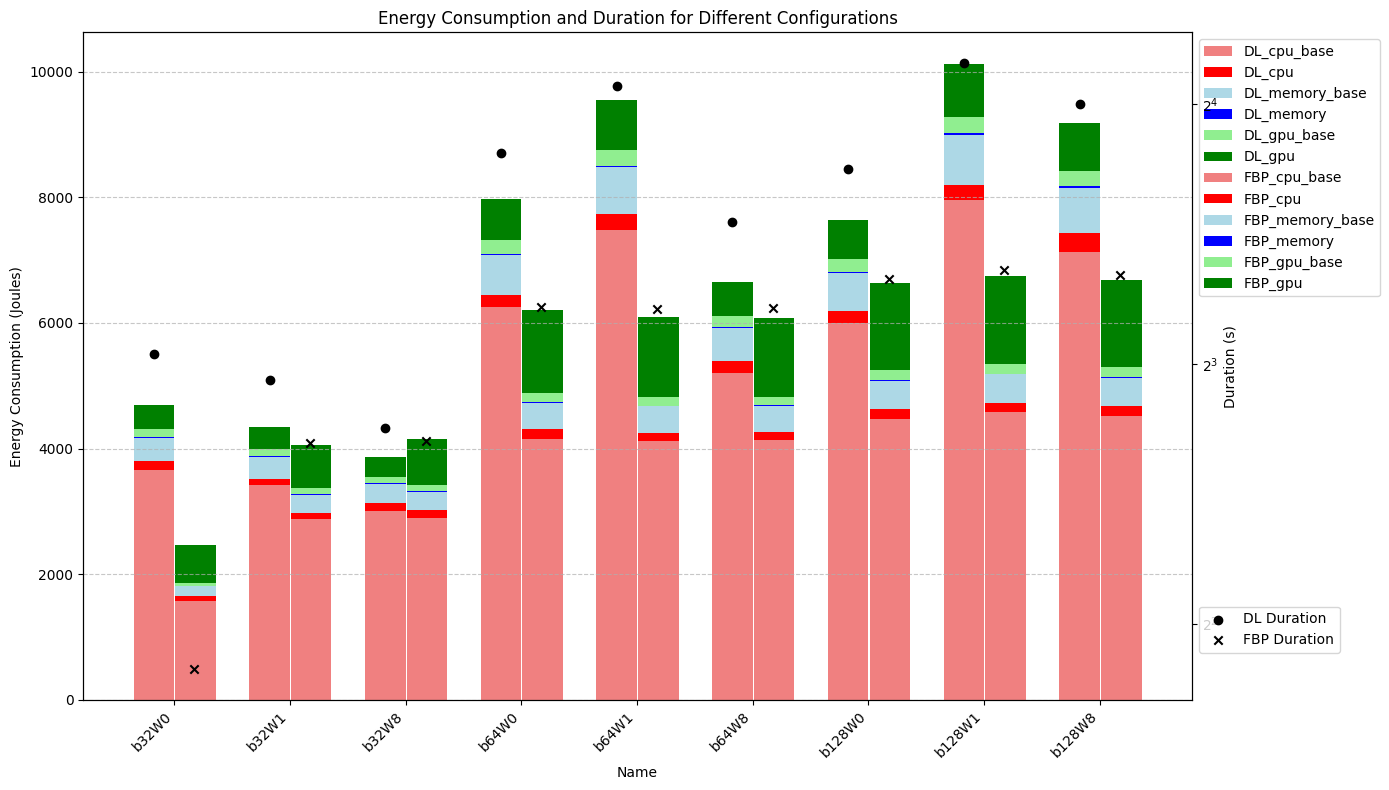

In [164]:
plot_energy_duration(final_df, ['b32W0','b32W1','b32W8','b64W0','b64W1','b64W8','b128W0','b128W1','b128W8' ])


Statistical Summary:

Name: b32W1
  Data Loading took 54.2% time between Data Loading + FBP
  Data Loading consumed 51.7% of total energy consumption of Data Loading + FBP

Name: b32W8
  Data Loading took 50.9% time between Data Loading + FBP
  Data Loading consumed 48.2% of total energy consumption of Data Loading + FBP

Name: b64W1
  Data Loading took 64.4% time between Data Loading + FBP
  Data Loading consumed 61.0% of total energy consumption of Data Loading + FBP

Name: b64W8
  Data Loading took 55.7% time between Data Loading + FBP
  Data Loading consumed 52.3% of total energy consumption of Data Loading + FBP

Name: b128W1
  Data Loading took 63.5% time between Data Loading + FBP
  Data Loading consumed 60.0% of total energy consumption of Data Loading + FBP

Name: b128W8
  Data Loading took 61.2% time between Data Loading + FBP
  Data Loading consumed 57.9% of total energy consumption of Data Loading + FBP


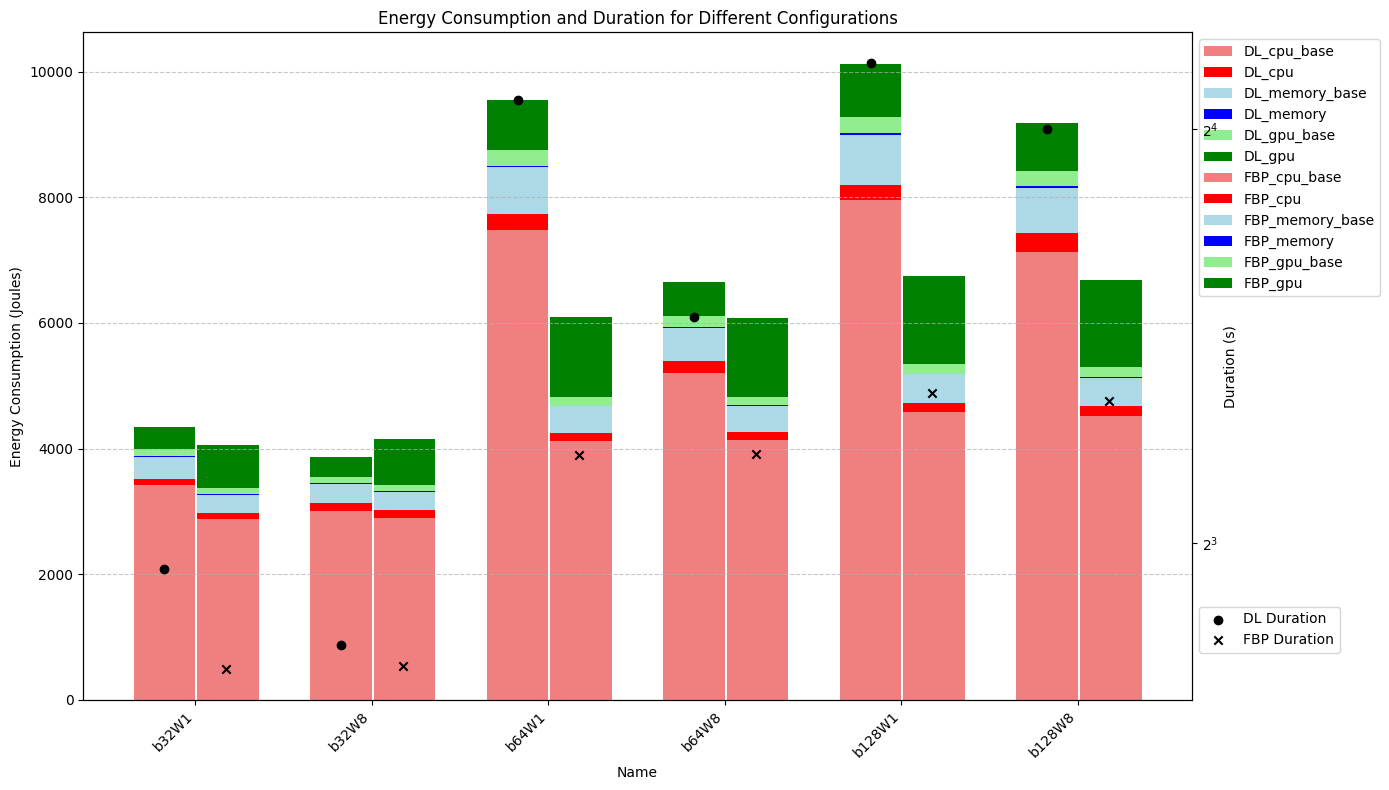

In [165]:
plot_energy_duration(final_df, ['b32W1','b32W8','b64W1','b64W8','b128W1','b128W8' ])